In [1]:
# iPython magic to autoreload modules everytime code is executed to propagate changes to the code
%load_ext autoreload
%autoreload 2

In [ ]:
import coderdata as cd
from coderdata.utils.stats import summarize_response_metric
from coderdata.utils.stats import plot_response_metric
from coderdata.utils.stats import prepare_2d_hist_data

import matplotlib.pyplot as plt
import math
import os

import seaborn as sns
import pandas as pd

In [2]:
os.makedirs('/tmp/coderdata', exist_ok=True)
os.chdir('/tmp/coderdata')

In [189]:
dataset_prefix = 'beataml'

In [10]:
# cd.download_data_by_prefix(dataset_prefix)

In [190]:
data = cd.DatasetLoader(dataset_prefix)
summary_stats = summarize_response_metric(data=data)
summary_stats

Processing Data...


,count,mean,std,min,25%,50%,75%,max
dose_response_metric,,,,,,,,
aac,23378.0,3.028061e-01,1.821265e-01,0.0000,0.166200,0.26375,0.415000,1.000000e+00
auc,23378.0,6.971939e-01,1.821265e-01,0.0000,0.585000,0.73625,0.833800,1.000000e+00
dss,23378.0,3.218484e-01,5.733492e-01,0.0000,0.000000,0.17750,0.346575,1.258000e+01
fit_auc,23378.0,5.530934e-01,2.074431e-01,0.0000,0.404000,0.53160,0.713500,2.667000e+00
fit_ec50,23378.0,5.113196e+00,2.553243e+00,-3.0000,4.534000,5.50350,6.675750,8.000000e+00
fit_ec50se,23378.0,5.279473e+08,6.163188e+10,0.0000,0.574600,1.55800,9.211500,9.117000e+12
fit_einf,23378.0,3.248612e-01,3.196515e-01,0.0000,0.000000,0.25620,0.611700,9.997000e-01
fit_hs,23378.0,-6.994430e-01,3.430275e-01,-1.0000,-1.000000,-0.88320,-0.396600,-0.000000e+00
fit_ic50,15622.0,6.404701e+00,3.819312e+00,-3.0000,5.460000,6.33700,7.024000,3.443000e+02


In [13]:
metrics = summary_stats.index.values

In [14]:
ncol = 3
nrow = math.ceil(len(metrics)/ncol)

Text(0.5, 0.98, 'Distribution of drug response values in "beataml"')

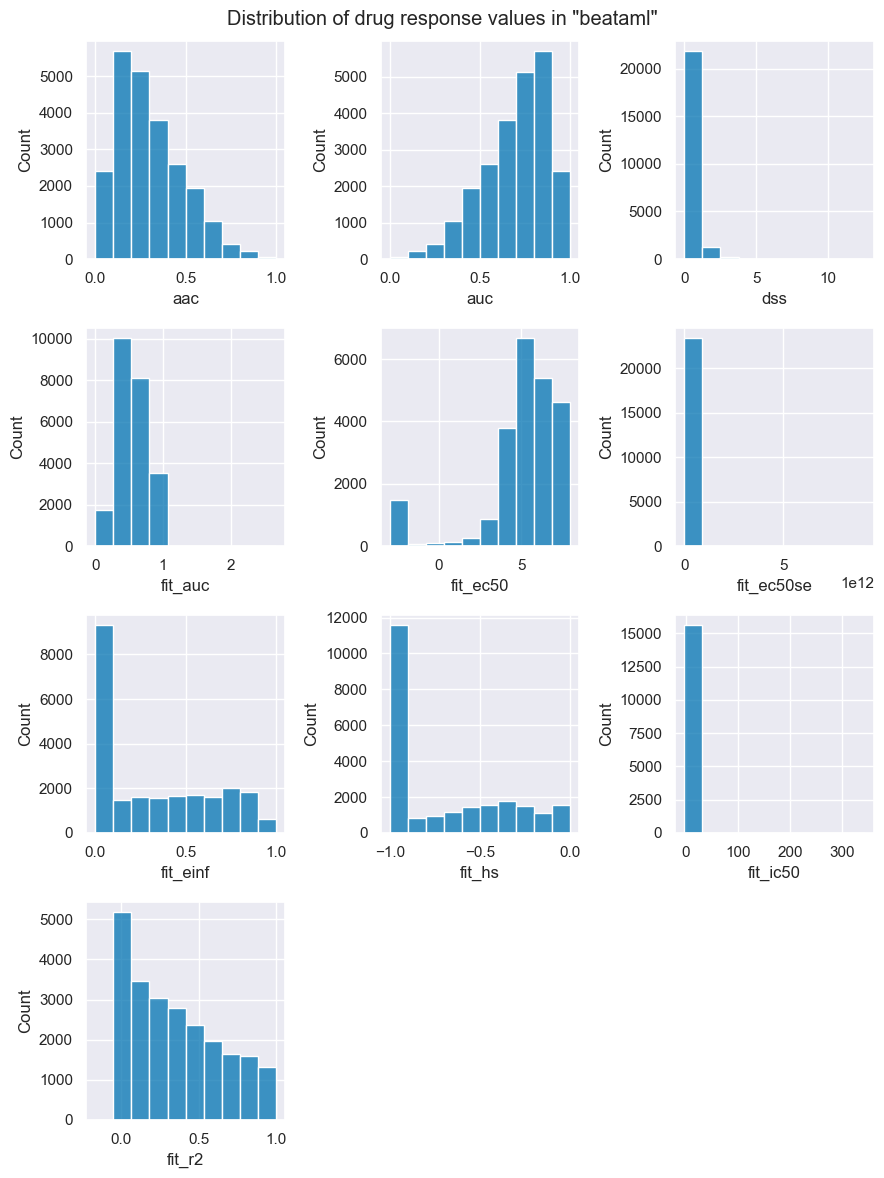

In [18]:
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*3, nrow*3))

k = 0
for i in range(0, nrow):
    for j in range(0, ncol):
        if k < len(metrics):
            plot_response_metric(data=data, metric=metrics[k], bins=10, ax=axs[i, j])
        else:
            axs[i, j].axis('off')
        k += 1

fig.set_layout_engine('tight')
fig.suptitle(f'Distribution of drug response values in "{dataset_prefix}"')

# uncomment next line to save plot
# fig.savefig(f'{dataset_prefix}.png')

For temporary import (development) of tabulated experiments files, i.e. the data that should normally be located in the `experiments` object of the data loaded via `cd.DatasetLoader()` we can also use pandas directly

In [ ]:
## Datasets from October (before allowing hill slope to be positive)

# experiment = "GDSC_v2"
# file_name = "gdsc2Output.tsv"

# experiment = "CTRP"
# file_name = "ctrpOutput.tsv"

# experiment = "NCI60"
# file_name = "nciOutput.tsv"

# data_experiments = pd.read_csv(file_name, sep='\t')

In [ ]:
## Dataset from 2024-11-01 (after allowing hill slope to be positive)

# experiment = "GDSC_v2-HillSlope+_R2-leq0-excluded"
# file_name = "gdsc2AllCurve.tsv"

experiment = "CTRP-HillSlope+_R2-leq0-excluded"
file_name = "ctrpAllCurve.tsv"

# experiment = "Prism-HillSlope+_R2-leq0-included"
# file_name = "prismAllCurve.tsv"

data_experiments = pd.read_csv(file_name, sep='\t')

Alternatively we just extract the `experiments` object of the data and prepare it for further plotting

In [191]:
experiment = "BeatAML"
data_experiments = data.experiments

We prepare the data table such that each drug_response_metric has it's own column with associated values

In [ ]:
data_plot = prepare_2d_hist_data(data_experiments, r2=0)
# data_plot = _prepare_2d_hist_data(data_experiments)


Finally we define the metrics we want to plot, generate the figure and save it.

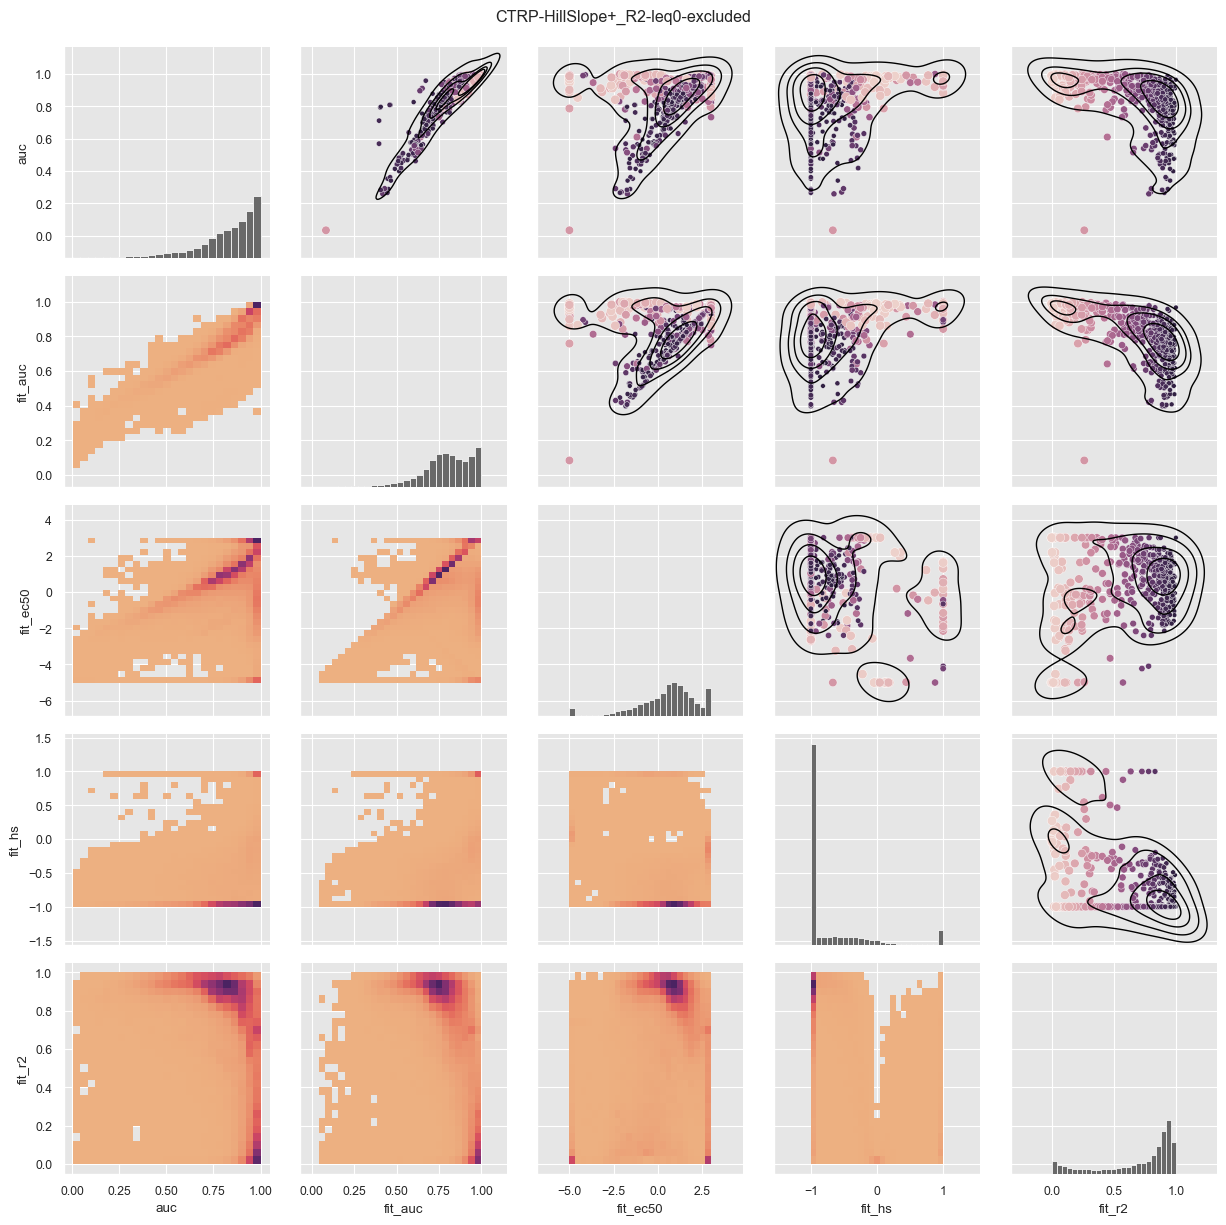

In [45]:
# metrics = [
#     "aac", "auc", "dss",
#     "fit_auc", "fit_ec50", "fit_ec50se",
#     "fit_einf", "fit_hs", "fit_ic50",
#     "fit_r2",
#     ]

metrics = ["auc", "fit_auc", "fit_ec50", "fit_hs", "fit_r2"]

# setting up the "theme context" aswell as the style
sns.set_theme(context="paper")
sns.set_style("darkgrid",{"axes.facecolor": ".9"})

# defining a color palette for the 2D histogram
joint_color_p = sns.color_palette("flare", as_cmap=True)

# generating an empty seaborn PairGrid object based on the plotting data
# the grid will be n x n where n is the number of metrics we plot 
pg = sns.PairGrid(
    data_plot,
    vars=metrics
    )

# generating the diagonal i.e. histograms of the drug response metric 
# value distributions
pg.map_diag(sns.histplot, bins=25, facecolor="dimgrey")

# generating the lower triangle of the grid where we plot 2D histograms
# of metric1 vs metric2 distributions
pg.map_lower(sns.histplot, bins=25, cmap=joint_color_p)

# subsampling the plotting data to 500 datapoints 
if data_plot.shape[0] > 500:
    pg.data = data_plot.sample(n=500, random_state=42)

# plotting the subsampled data as scatter plot in the upper triangle
# points are sized according to the inverse of their "fit_r2" value
# (larger points have a smaller "fit_r2 value")
# additionally the points are also colored according to their "fit_r2"
# value where darker hues are larger values
pg.map_upper(
    sns.scatterplot,
    size=max(pg.data["fit_r2"])-pg.data["fit_r2"],
    hue=pg.data["fit_r2"],
    )
# plotting a 2D kernel density distribution over the subsampled data 
# points in the upper triangle
pg.map_upper(sns.kdeplot, levels=5, color="black", linewidths=1 )

# adjusting the size of the top margin of grid and giving the plot a 
# title
pg.figure.subplots_adjust(top=.95)
pg.figure.suptitle(f"{experiment}")

# saving the plot according to the experiment name
pg.savefig(f"{experiment}-combined.pdf")

In [ ]:
data_for_corr = data_plot.drop(columns=["source", "improve_sample_id", "improve_drug_id", "study", "time", "time_unit", "fit_r2"])
data_for_corr

,aac,auc,dss,fit_auc,fit_ec50,fit_ec50se,fit_einf,fit_hs,fit_ic50
0,0.0085,0.9915,0.0000,0.8341,1.6940,29.9400,0.0000,-1.0000,1.694
1,0.2144,0.7856,0.0000,0.8408,-0.0845,0.3520,0.5871,-1.0000,NaN
2,0.0317,0.9683,0.0000,0.9736,-3.2480,3.9120,0.9661,-1.0000,NaN
3,0.0478,0.9522,0.0000,0.9531,-4.8110,0.0000,0.9043,-0.0000,NaN
4,0.0750,0.9250,0.0000,0.8740,0.6171,1.0910,0.5773,-1.0000,NaN
...,...,...,...,...,...,...,...,...,...
28184,0.3374,0.6626,0.0000,0.6795,1.9100,132.9000,0.0000,-0.1234,1.910
28185,0.2304,0.7696,0.0000,0.7238,1.0950,6.7230,0.0000,-0.3090,1.095
28186,0.6067,0.3933,0.2524,0.5243,-2.4360,0.1554,0.2995,-0.8393,-1.963
28187,0.0000,1.0000,0.0000,1.0000,6.7770,8908.0000,0.8690,-0.6641,NaN


In [ ]:
sp_corr = data_for_corr.corr(method="spearman")
sp_corr

,aac,auc,dss,fit_auc,fit_ec50,fit_ec50se,fit_einf,fit_hs,fit_ic50
aac,1.000000,-1.000000,0.646678,-0.801279,-0.416704,-0.185229,-0.390141,-0.260748,-0.745337
auc,-1.000000,1.000000,-0.646678,0.801279,0.416704,0.185229,0.390141,0.260748,0.745337
dss,0.646678,-0.646678,1.000000,-0.669341,-0.323620,-0.210319,-0.334971,-0.370911,-0.721558
fit_auc,-0.801279,0.801279,-0.669341,1.000000,0.321784,0.009285,0.683366,0.431902,0.953979
fit_ec50,-0.416704,0.416704,-0.323620,0.321784,1.000000,0.287325,-0.173945,0.496219,0.953891
fit_ec50se,-0.185229,0.185229,-0.210319,0.009285,0.287325,1.000000,-0.492439,-0.162944,0.873178
fit_einf,-0.390141,0.390141,-0.334971,0.683366,-0.173945,-0.492439,1.000000,0.289245,-0.390772
fit_hs,-0.260748,0.260748,-0.370911,0.431902,0.496219,-0.162944,0.289245,1.000000,0.608225
fit_ic50,-0.745337,0.745337,-0.721558,0.953979,0.953891,0.873178,-0.390772,0.608225,1.000000


In [109]:
import seaborn as sns

In [164]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
cmap_1 = LinearSegmentedColormap.from_list("cmap_1", ["#fc8d59", "#ffffbf", "#91bfdb"])
cmap_2 = LinearSegmentedColormap.from_list("cmap_2", ["#f1a340", "#f7f7f7", "#998ec3"])
cmap_3 = LinearSegmentedColormap.from_list("cmap_3", ["#ef8a62", "#f7f7f7", "#67a9cf"])
mpl.colormaps.unregister("cmap_1")
mpl.colormaps.unregister("cmap_2")
mpl.colormaps.unregister("cmap_3")
mpl.colormaps.register(cmap=cmap_1)
mpl.colormaps.register(cmap=cmap_2)
mpl.colormaps.register(cmap=cmap_3)

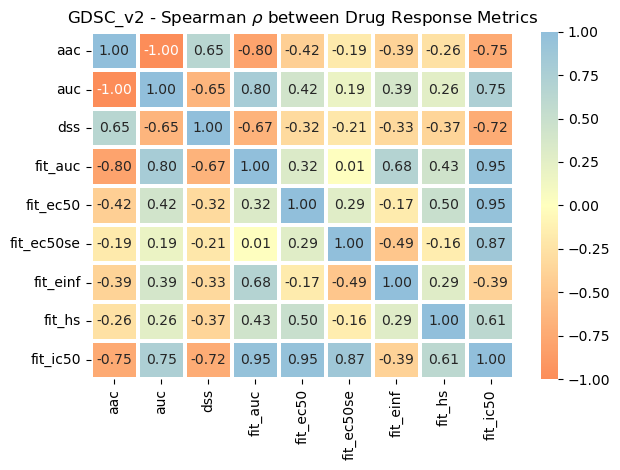

In [ ]:
fig, ax = plt.subplots()

sns.heatmap(
    sp_corr,
    ax=ax,
    annot=True,
    linewidth=1.5,
    fmt=".2f",
    cmap="cmap_1",
    robust=True,
    vmin=-1,
    vmax=1,
    )
rho = r"$\rho$"
plt.title(f"{experiment} - Spearman {rho} between Drug Response Metrics")
plt.tight_layout()
plt.savefig(f"{experiment}-spearman-heatmap.pdf")